# Introduction

    
This tutorial leverages the [gpt2-medium-finetuned-sst2-sentiment](https://huggingface.co/michelecafagna26/gpt2-medium-finetuned-sst2-sentiment?text=tiembla+Enrique+iglesias+que+ya+lleg%C3%B3+Luis+fonsi+y+tiene+la+fama+de+no+darse+por+vencido+%3Av) model for Multilingual Sentiment Analysis on YouTube Comments. We have extracted the dataset from comments on the most-watched video on YouTube, [Despacito](https://www.youtube.com/watch?v=kJQP7kiw5Fk) by Luis Fonsi, where we have comments in multiple languages including Spanish, English, and more.

You can use this method on almost every YouTube video. It will extract comments. You'll need the [YouTube Data API v3](https://console.cloud.google.com/) and a YouTube ID. Then, run the `youtube_sentiment_analysis.py` file, or simply execute the following command:
```bash
!python youtube_sentiment_analysis.py --api_key your_api_key --video_id your_video_id
```

In [1]:
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from googleapiclient.discovery import build
import torch
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
gpt2 = 'michelecafagna26/gpt2-medium-finetuned-sst2-sentiment'

tokenizer = GPT2Tokenizer.from_pretrained(gpt2)
model = GPT2ForSequenceClassification.from_pretrained(gpt2)

In [3]:
test = "love it!"
inputs = tokenizer(test, return_tensors="pt", max_length=512, truncation=True)
outputs = model(**inputs)
pred_class = torch.argmax(outputs.logits, dim=1).item()

# 0: negative, 1: positive
pred_class

1

In [4]:
api_key = ''    ## get yours from > https://console.cloud.google.com/
video_id = 'kJQP7kiw5Fk'                        

youtube = build('youtube', 'v3', developerKey=api_key)
comments = []
next_page_token = None

while True:
    response = youtube.commentThreads().list(
        part='snippet',
        videoId=video_id,
        maxResults=100,     # adjust based on computational resources
        pageToken=next_page_token if next_page_token else ''
    ).execute()

    for item in response['items']:
        comment = item['snippet']['topLevelComment']['snippet']['textDisplay']
        comments.append(comment)

    next_page_token = response.get('nextPageToken')

    if not next_page_token:
        break

In [5]:
len(comments)

437400

In [6]:
df = pd.DataFrame(np.array(comments[:500]), columns=['comments'])
len(df)

500

In [7]:
def sentiment(comment):
    inputs = tokenizer(comment, return_tensors="pt", max_length=512, truncation=True)
    outputs = model(**inputs)
    pred_class = torch.argmax(outputs.logits, dim=1).item()
    
    if pred_class == 0:
        return("Negative Comment")
    else:
        return("Positive Comment")

In [8]:
test_comment = df['comments'].iloc[5] # random test

print (test_comment)
sentiment(test_comment)

Muito bom 😊😊


'Positive Comment'

In [9]:
df['sentiment'] = df['comments'].apply(lambda x: sentiment(x[:512]))

In [10]:
df.head()

,comments,sentiment
0,chak de fat de india who is from india,Positive Comment
1,Anybody from 2024--------------&gt;,Positive Comment
2,The fact you realise that this song views are ...,Positive Comment
3,Who is watching this masterpiece in 14 feb 2024,Positive Comment
4,I remember listening to this when it came out,Positive Comment


In [11]:
# save the dataframe
df.to_csv('despacito_comments.csv', index=False, header=True)

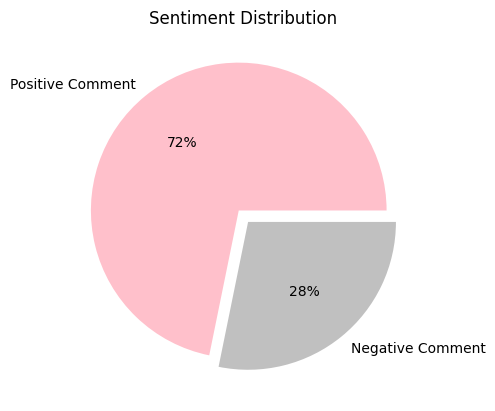

In [11]:
# plot for quick 
sent_counts = df['sentiment'].value_counts(normalize=True)
sent_counts.plot(kind='pie', autopct='%1.0f%%', colors=['pink', 'silver'], explode=(0.05, 0.05))
plt.title('Sentiment Distribution')
plt.ylabel('')
plt.savefig('visuals/despacito_sentiment_distribution.png')
plt.show()

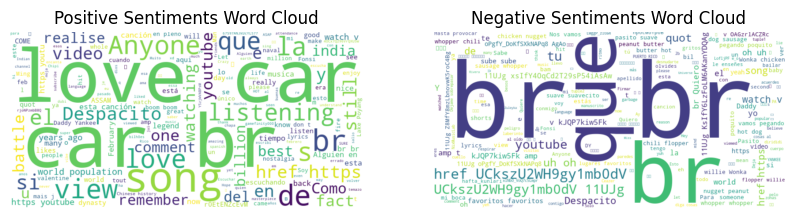

In [12]:
# worlcloud for positive and negative comments
pos_words = ' '.join(df[df['sentiment'] == 'Positive Comment']['comments'])
neg_words = ' '.join(df[df['sentiment'] == 'Negative Comment']['comments'])

# Word cloud for positive sentiments
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(pos_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Positive Sentiments Word Cloud')
plt.axis('off')

# Word cloud for negative sentiments
plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(neg_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Negative Sentiments Word Cloud')
plt.axis('off')
plt.savefig('visuals/despacito_word_cloud.png')
plt.show()
